<h1>LSTM Time Series Forecasting </h1>
<li>Univariate Model</li>

1. Load in Data

In [1]:
'''Import preprocessing libraries'''
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
'''Read in Data'''
train = pd.read_csv('DailyClimateTrain.csv')
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


2. EDA

In [3]:
'''Check data shape'''
train.shape

(1462, 5)

In [4]:
'''Set index to date column'''
train.index = pd.to_datetime(train['date'], format='%Y.%m.%d')
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
date,,,,,
2013-01-01,2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,2013-01-05,6.000000,86.833333,3.700000,1016.500000


<Axes: xlabel='date'>

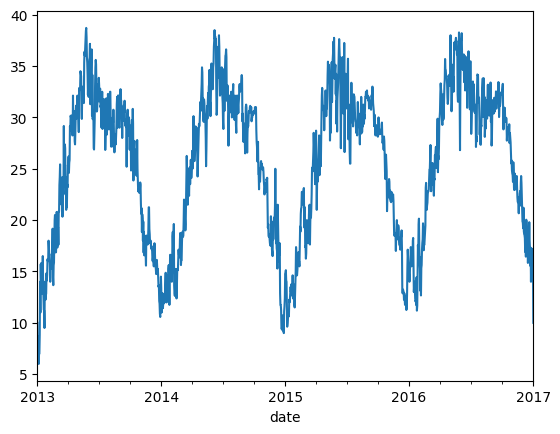

In [5]:
'''Analyze target variable: Plot'''
temp = train['meantemp']
temp.plot()

3. Preprocessing

In [6]:
'''Create sliding window for prediction
e.g.:
X = [[[1], [2], [3], [4], [5]]] -> Y = [6]
X = [[[2], [3], [4], [5], [6]]] -> Y = [7]
...'''
def sliding_window(df, window_size):
    df_as_np = df.to_numpy()    #Convert dataframe to numpy array
    x = []    #List of inputs
    y = []    #List of outputs
    for i in range(len(df_as_np)-window_size):    #Iterate through dataframe for windowsize
        row = [[a] for a in df_as_np[i:i+window_size]]    #Input is a list of list (A tensor)
        x.append(row)    #Append tensor to x
        label = df_as_np[i+window_size]    #Output is a list with single prediction
        y.append(label)    #Append to output
    return np.array(x), np.array(y)    #Return lists as array

In [7]:
'''Call sliding window on target variable dataframe'''
WINDOW_SIZE = 7
x, y = sliding_window(temp, WINDOW_SIZE)
x.shape, y.shape    
#x = (1455 rows, 7 items per row nested inside of: 1 list per row)
#y = (1455 rows, single item)

((1455, 7, 1), (1455,))

In [8]:
'''Train test split'''
x_train, y_train = x[:1000], y[:1000] #First 1000 points for training
x_test, y_test = x[1000:], y[1000:]
x_train[:2], y_train[:2]

(array([[[10.        ],
         [ 7.4       ],
         [ 7.16666667],
         [ 8.66666667],
         [ 6.        ],
         [ 7.        ],
         [ 7.        ]],
 
        [[ 7.4       ],
         [ 7.16666667],
         [ 8.66666667],
         [ 6.        ],
         [ 7.        ],
         [ 7.        ],
         [ 8.85714286]]]),
 array([ 8.85714286, 14.        ]))

4. Model Training

In [9]:
'''Import Tensorflow'''
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [10]:
'''Instantiate model'''
model = Sequential(
    [layers.InputLayer((WINDOW_SIZE,1)),
    layers.LSTM(64),
    layers.Dense(8, 'relu'),
    layers.Dense(1, 'linear')]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
'''Callbacks'''
cp = ModelCheckpoint('model/', save_best_only=True)

In [12]:
'''Compile Model'''
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [14]:
'''Train model'''
model.fit(x_train, y_train, epochs=100, callbacks=[cp])

Epoch 1/100
32/32 [==============================] - 0s 5ms/step - loss: 140.2486 - root_mean_squared_error: 11.8427
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 133.0999 - root_mean_squared_error: 11.5369
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 126.4258 - root_mean_squared_error: 11.2439
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 120.2904 - root_mean_squared_error: 10.9677
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 114.5188 - root_mean_squared_error: 10.7013
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 109.1808 - root_mean_squared_error: 10.4490
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 104.1177 - root_mean_squared_error: 10.2038
Epoch 8/100
32/32 [==============================] - 0s 4ms/step - loss: 98.7838 - root_mean_squared_error: 9.9390
Epoch 9/100
32/32 [==============================] - 0s 4ms/step -

In [ ]:
# '''Load best model'''
# from tensorflow.keras.models import load_model
# model = load_model('model/')

OSError: SavedModel file does not exist at: model/\{saved_model.pbtxt|saved_model.pb}

In [15]:
'''Predict training data and compare to original'''
train_predictions = model.predict(x_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Train Actual':y_train})
train_results.head()

32/32 [==============================] - 1s 3ms/step


,Train Predictions,Train Actual
0,9.646939,8.857143
1,10.395071,14.000000
2,13.256655,11.000000
3,12.126492,15.714286
4,14.537414,14.000000


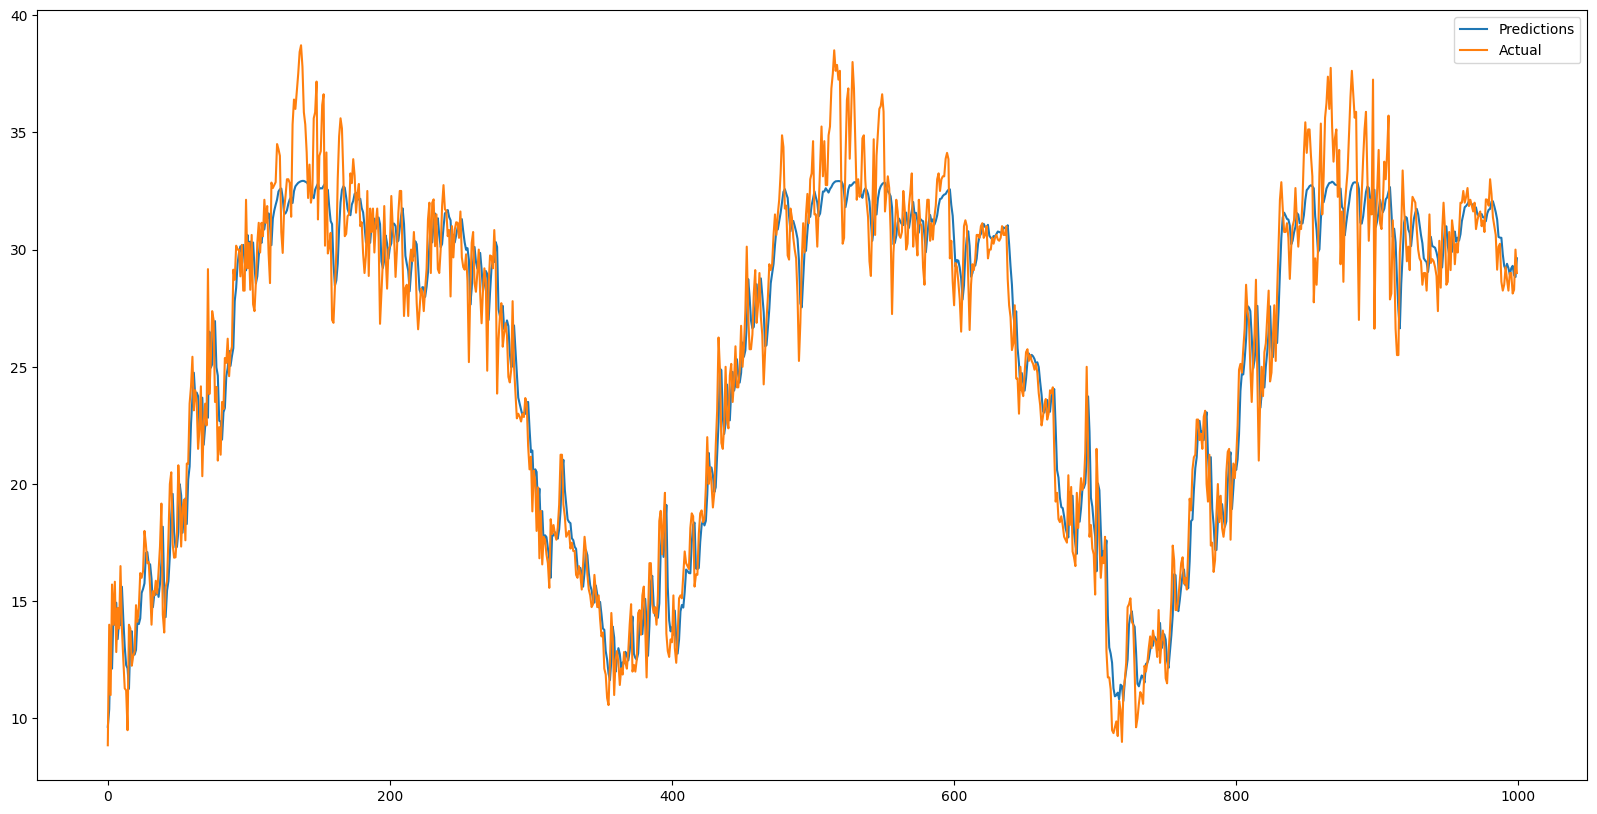

In [16]:
'''Plot prediction vs actual (Train data)'''
plt.figure(figsize=(20,10))
plt.plot(train_results['Train Predictions'], label='Predictions')
plt.plot(train_results['Train Actual'], label='Actual')
plt.legend()

In [17]:
'''Repeat with test data'''
test_predictions = model.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Test Actual':y_test})
test_results.head()

15/15 [==============================] - 0s 2ms/step


,Test Predictions,Test Actual
0,29.471165,28.875
1,29.372538,28.375
2,29.130192,28.625
3,29.124855,28.375
4,28.959623,28.500


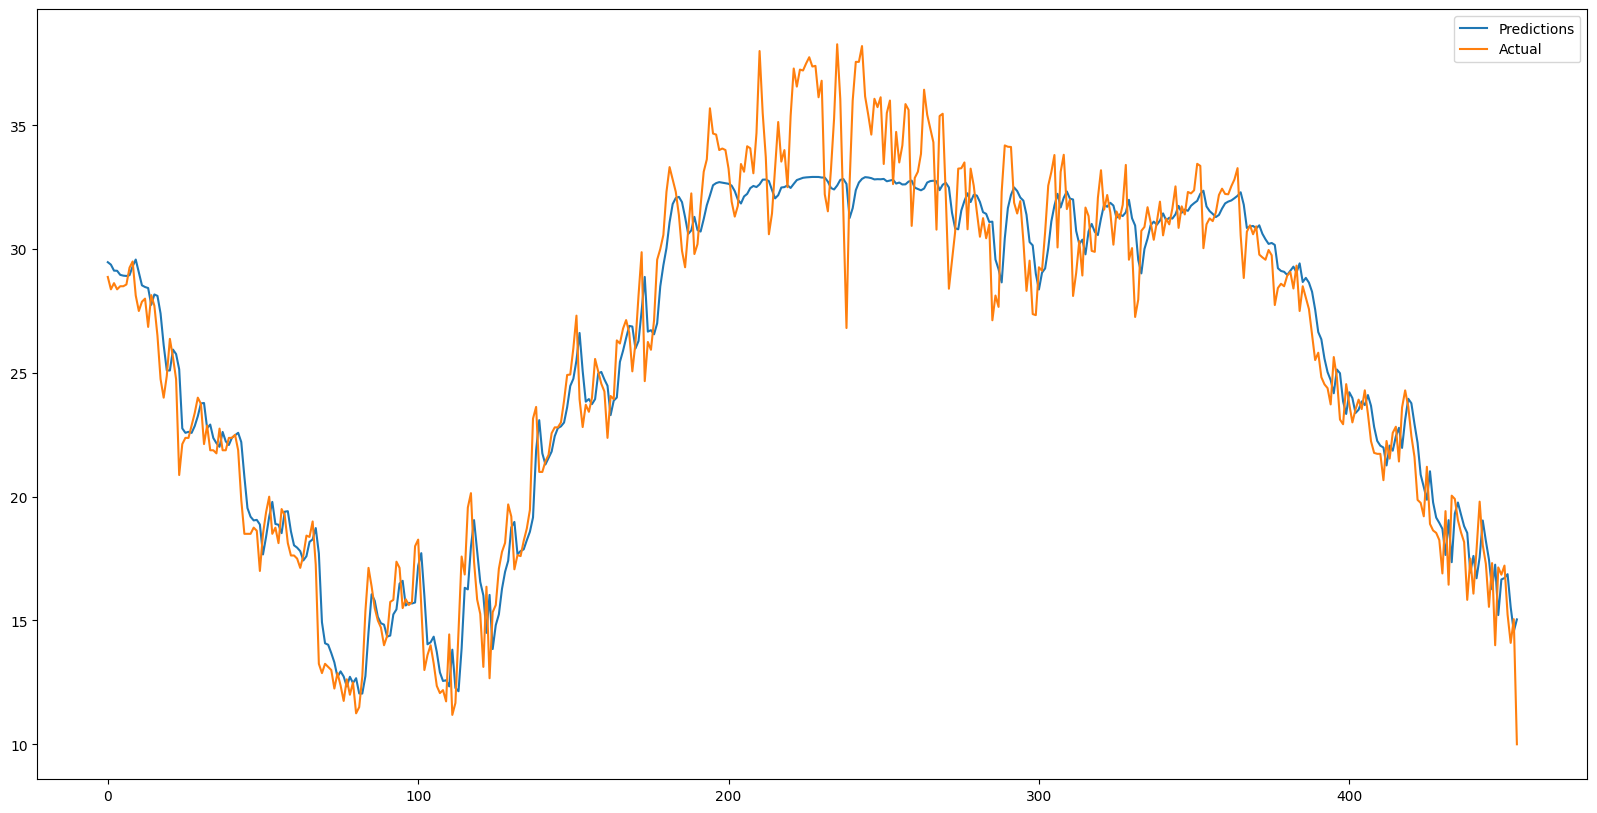

In [18]:
'''Plot prediction vs actual (Test data)'''
plt.figure(figsize=(20,10))
plt.plot(test_results['Test Predictions'], label='Predictions')
plt.plot(test_results['Test Actual'], label='Actual')
plt.legend()

<h1>Multivariate Analysis

In [19]:
'''Load in original dataset'''
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
date,,,,,
2013-01-01,2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [26]:
'''Pipeline for predictions'''
from sklearn.metrics import mean_squared_error as mse 

def plot_predictions(model, x, y, start=0, end=len(x)):
    predictions = model.predict(x).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actual':y})
    plt.figure(figsize=(20,10))
    plt.plot(df['Predictions'], label='Predictions')
    plt.plot(df['Actual'], label='Actual')
    return df, mse(y, predictions)

15/15 [==============================] - 0s 3ms/step


(     Predictions     Actual
 0      29.471165  28.875000
 1      29.372538  28.375000
 2      29.130192  28.625000
 3      29.124855  28.375000
 4      28.959623  28.500000
 ..           ...        ...
 450    16.713835  17.217391
 451    16.870977  15.238095
 452    15.540273  14.095238
 453    14.560136  15.052632
 454    15.043174  10.000000
 
 [455 rows x 2 columns],
 3.163885237004221)

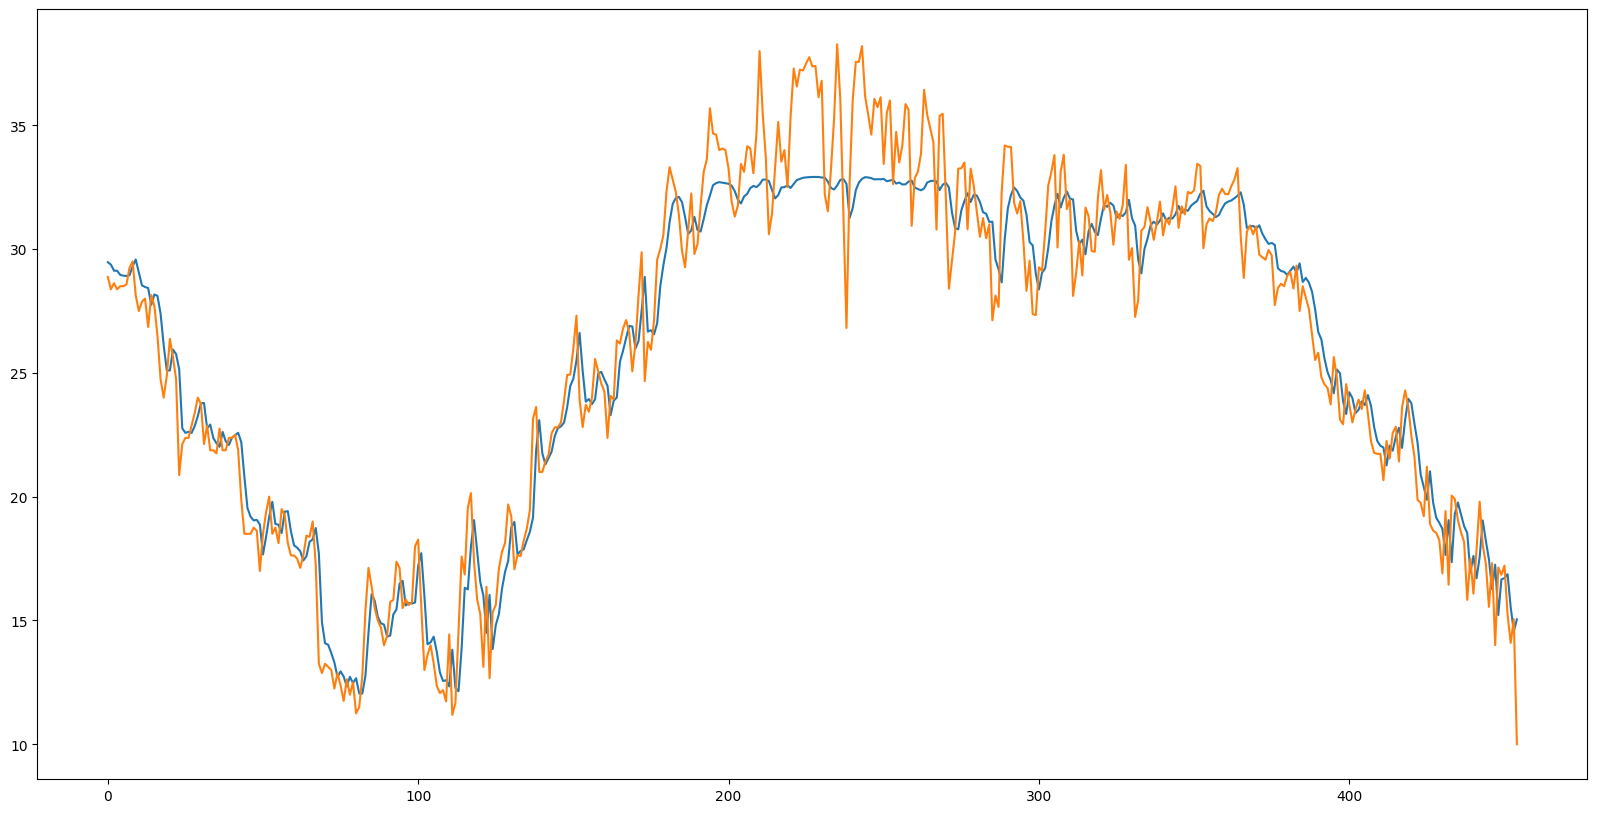

In [27]:
plot_predictions(model, x_test, y_test)

Train Different Models

In [55]:
'''Create second model
Replace LSTM with Convolutional 1D layer
'''
model2 = Sequential(
    [layers.InputLayer((WINDOW_SIZE,1)),
    layers.Conv1D(64, kernel_size=1),
    layers.Dense(8, 'relu'),
    layers.Dense(1, 'linear')]
    )

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 7, 64)             128       
                                                                 
 dense_10 (Dense)            (None, 7, 8)              520       
                                                                 
 dense_11 (Dense)            (None, 7, 1)              9         
                                                                 
Total params: 657 (2.57 KB)
Trainable params: 657 (2.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
'''Compile model'''
model2.compile(loss=MeanSquaredError(), optimizer='Adam', metrics=[RootMeanSquaredError()])

In [54]:
'''Train model 2'''
model2.fit(x_train, y_train, epochs=50)

Epoch 1/50
32/32 [==============================] - 0s 2ms/step - loss: 54.5213 - root_mean_squared_error: 7.3882
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 54.3573 - root_mean_squared_error: 7.3593
Epoch 3/50
32/32 [==============================] - 0s 1ms/step - loss: 54.0936 - root_mean_squared_error: 7.3641
Epoch 4/50
32/32 [==============================] - 0s 1ms/step - loss: 54.5786 - root_mean_squared_error: 7.3915
Epoch 5/50
32/32 [==============================] - 0s 1ms/step - loss: 53.7502 - root_mean_squared_error: 7.3303
Epoch 6/50
32/32 [==============================] - 0s 1ms/step - loss: 53.5530 - root_mean_squared_error: 7.3263
Epoch 7/50
32/32 [==============================] - 0s 1ms/step - loss: 54.6355 - root_mean_squared_error: 7.3786
Epoch 8/50
32/32 [==============================] - 0s 1ms/step - loss: 54.2696 - root_mean_squared_error: 7.3671
Epoch 9/50
32/32 [==============================] - 0s 1ms/step - loss: 55.4172 - root_m

In [53]:
'''Plot predictions'''
plot_predictions(model2, x_test, y_test)

15/15 [==============================] - 0s 826us/step


ValueError: All arrays must be of the same length

In [37]:
'''Create third model
Replace LSTM with Gated Recurrent Units layer
'''
model3 = Sequential(
    [layers.InputLayer((WINDOW_SIZE,1)),
    layers.GRU(64),
    layers.Dense(8, 'relu'),
    layers.Dense(1, 'linear')]
    )

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
'''Compile model'''
model3.compile(loss=MeanSquaredError(), optimizer='Adam', metrics=[RootMeanSquaredError()])

In [42]:
'''Train model 3'''
model3.fit(x_train, y_train, epochs=32)

Epoch 1/32
32/32 [==============================] - 0s 4ms/step - loss: 2.6824 - root_mean_squared_error: 1.6378
Epoch 2/32
32/32 [==============================] - 0s 4ms/step - loss: 2.6877 - root_mean_squared_error: 1.6394
Epoch 3/32
32/32 [==============================] - 0s 4ms/step - loss: 2.6933 - root_mean_squared_error: 1.6411
Epoch 4/32
32/32 [==============================] - 0s 4ms/step - loss: 2.7178 - root_mean_squared_error: 1.6486
Epoch 5/32
32/32 [==============================] - 0s 4ms/step - loss: 2.6703 - root_mean_squared_error: 1.6341
Epoch 6/32
32/32 [==============================] - 0s 6ms/step - loss: 2.6978 - root_mean_squared_error: 1.6425
Epoch 7/32
32/32 [==============================] - 0s 5ms/step - loss: 2.6573 - root_mean_squared_error: 1.6301
Epoch 8/32
32/32 [==============================] - 0s 6ms/step - loss: 2.7897 - root_mean_squared_error: 1.6703
Epoch 9/32
32/32 [==============================] - 0s 5ms/step - loss: 2.6827 - root_mean_squar

15/15 [==============================] - 0s 2ms/step


(     Predictions     Actual
 0      28.351938  28.875000
 1      28.667446  28.375000
 2      28.196499  28.625000
 3      28.448263  28.375000
 4      28.075794  28.500000
 ..           ...        ...
 450    16.807449  17.217391
 451    15.749819  15.238095
 452    14.990887  14.095238
 453    13.561457  15.052632
 454    14.807207  10.000000
 
 [455 rows x 2 columns],
 2.661112617518694)

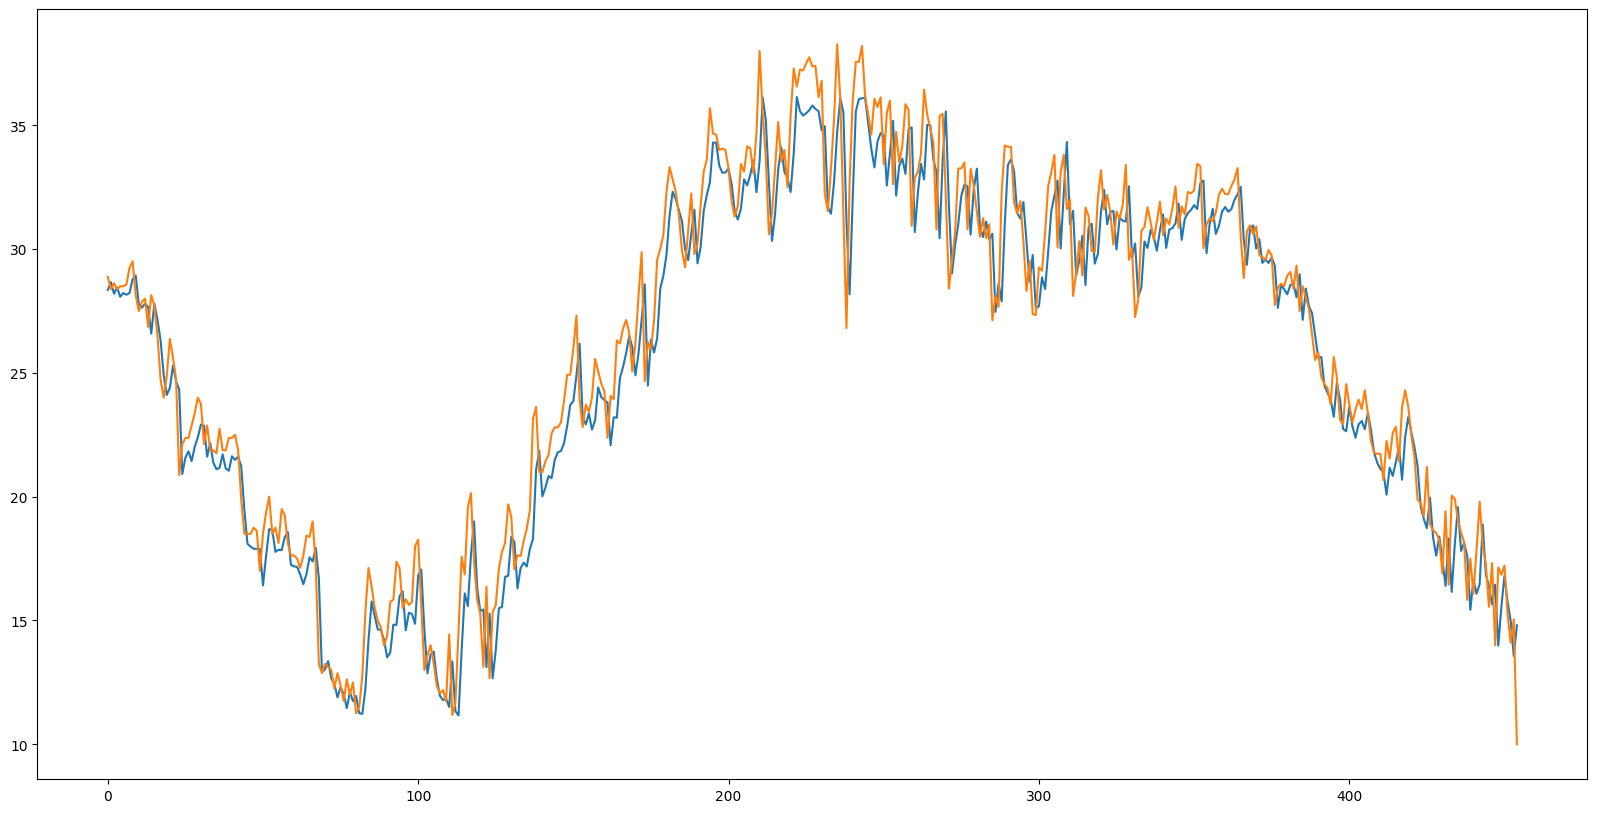

In [46]:
'''Plot predictions'''
plot_predictions(model3, x_test, y_test)

Multivariate analysis

In [58]:
'''Add seconds column to temperature'''
temp_df = pd.DataFrame({'Temperature': temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df.head()

,Temperature,Seconds
date,,
2013-01-01,10.000000,1.356998e+09
2013-01-02,7.400000,1.357085e+09
2013-01-03,7.166667,1.357171e+09
2013-01-04,8.666667,1.357258e+09
2013-01-05,6.000000,1.357344e+09


In [69]:
'''Add variables for multivariate analysis'''
day = 60*60*24
year = 365.2425*day

temp_df['Day Sine'] = np.sin(temp_df['Seconds'] * (2 * np.pi / day))  #Creates a sine signal from seconds for day
temp_df['Day Cosine'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))  #Creates a cosine signal from seconds for day
temp_df['Year Sine'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))  #Creates a sine signal from seconds for year
temp_df['Year Cosine'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))  #Creates a cosine signal from seconds for year
temp_df = temp_df.drop(columns=['Seconds'])
temp_df.head()

,Temperature,Day Sine,Day Cosine,Year Sine,Year Cosine
date,,,,,
2013-01-01,10.000000,-8.039063e-12,1.0,0.009848,0.999952
2013-01-02,7.400000,-3.740524e-12,1.0,0.027048,0.999634
2013-01-03,7.166667,5.580146e-13,1.0,0.044240,0.999021
2013-01-04,8.666667,-9.695362e-12,1.0,0.061418,0.998112
2013-01-05,6.000000,-5.396823e-12,1.0,0.078579,0.996908


In [70]:
'''Create sliding window with multiple variables for prediction
e.g.:
X = [[[t1, ds1], [t2, ds2], [t3, ds3], [t4, ds4], [t5, ds5]]] -> Y = [t6]
X = [[[t2, ds2], [t3, ds3], [t4, ds4], [t5, ds5], [t6, ds6]]] -> Y = [t7]
...
'''

def sliding_window2(df, window_size=WINDOW_SIZE):
    df_as_np = df.to_numpy()    #Convert dataframe to numpy array
    x = []    #List of inputs. Shape=(Training samples x time steps x number of variables)
    y = []    #List of outputs
    for i in range(len(df_as_np)-window_size):    #Iterate through dataframe for windowsize
        row = [a for a in df_as_np[i:i+window_size]]    #Input is a list of list (A tensor)
        x.append(row)    #Append tensor to x
        label = df_as_np[i+window_size][0]    #Output is a list with single prediction
        y.append(label)    #Append to output
    return np.array(x), np.array(y)    #Return lists as array

In [71]:
'''Call sliding window'''
x2, y2 = sliding_window2(temp_df)
x2.shape, y2.shape #X-Shape=(Training samples x time steps x number of variables)

((1455, 7, 5), (1455,))

In [72]:
'''Train test split'''
x2_train, y2_train = x2[:1000], y2[:1000]
x2_test, y2_test = x2[1000:], y2[1000:]

In [75]:
'''Scale data - temp'''
temp_training_mean = np.mean(x2_train[:, :, 0])
temp_training_std = np.std(x2_train[:, :, 0])

def preprocess(x):
    x[:, :, 0] = (x[:, :, 0] - temp_training_mean) / temp_training_std
    return x

In [76]:
'''Scale data'''
preprocess(x2_train)

array([[[-2.08038935e+00, -8.03906267e-12,  1.00000000e+00,
          9.84843067e-03,  9.99951503e-01],
        [-2.43162889e+00, -3.74052404e-12,  1.00000000e+00,
          2.70480678e-02,  9.99634134e-01],
        [-2.46315039e+00,  5.58014578e-13,  1.00000000e+00,
          4.42397007e-02,  9.99020945e-01],
        ...,
        [-2.62075788e+00, -5.39682341e-12,  1.00000000e+00,
          7.85786075e-02,  9.96907921e-01],
        [-2.48566575e+00, -1.09828478e-12,  1.00000000e+00,
          9.57157195e-02,  9.95408711e-01],
        [-2.48566575e+00, -1.13516614e-11,  1.00000000e+00,
          1.12824507e-01,  9.93614931e-01]],

       [[-2.43162889e+00, -3.74052404e-12,  1.00000000e+00,
          2.70480678e-02,  9.99634134e-01],
        [-2.46315039e+00,  5.58014578e-13,  1.00000000e+00,
          4.42397007e-02,  9.99020945e-01],
        [-2.26051219e+00, -9.69536203e-12,  1.00000000e+00,
          6.14182418e-02,  9.98112118e-01],
        ...,
        [-2.48566575e+00, -1.0982847

Train Model

In [77]:
'''Instantiate model4'''
model4 = Sequential(
    [layers.InputLayer((WINDOW_SIZE,5)), #Window size x Number of variables
    layers.LSTM(64),
    layers.Dense(8, 'relu'),
    layers.Dense(1, 'linear')]
)
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18449 (72.07 KB)
Trainable params: 18449 (72.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
'''Compile'''
model4.compile(optimizer='Adam', loss='MeanSquaredError', metrics=['RootMeanSquaredError'])

In [79]:
'''Train'''
model4.fit(x2_train, y2_train, epochs=50)

Epoch 1/50
32/32 [==============================] - 3s 4ms/step - loss: 658.8167 - root_mean_squared_error: 25.6674
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 413.6455 - root_mean_squared_error: 20.3383
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 212.9142 - root_mean_squared_error: 14.5916
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 129.4734 - root_mean_squared_error: 11.3786
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 83.8773 - root_mean_squared_error: 9.1585
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 62.9022 - root_mean_squared_error: 7.9311
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 53.8399 - root_mean_squared_error: 7.3376
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 34.6709 - root_mean_squared_error: 5.8882
Epoch 9/50
32/32 [==============================] - 0s 5ms/step - loss: 16.3570 

 1/15 [=>............................] - ETA: 0s

15/15 [==============================] - 0s 4ms/step


(     Predictions     Actual
 0      19.460714  28.875000
 1      19.440081  28.375000
 2      19.433516  28.625000
 3      19.420874  28.375000
 4      19.416691  28.500000
 ..           ...        ...
 450    24.552414  17.217391
 451    24.463375  15.238095
 452    24.779243  14.095238
 453    25.189571  15.052632
 454    25.200214  10.000000
 
 [455 rows x 2 columns],
 107.98101772229867)

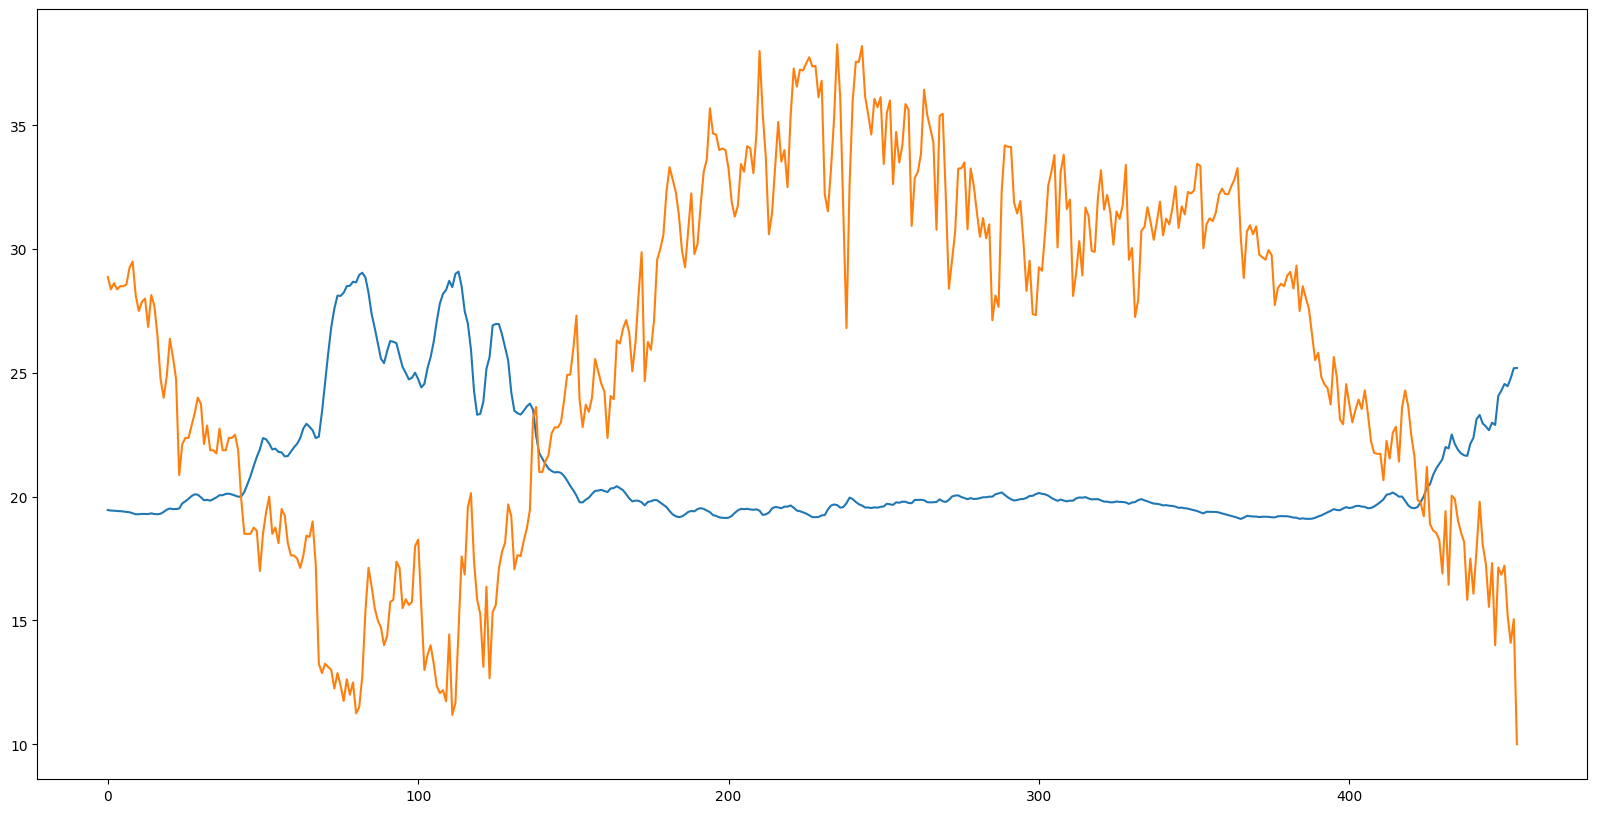

In [82]:
'''Plot predictions'''
plot_predictions(model4, x2_test, y2_test)

Using given data in forecast

In [88]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
date,,,,,
2013-01-01,2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [89]:
'''Create duplicate df'''
train2 = train.drop(columns=['date'])
train2.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [90]:
def sliding_window3(df, window_size=WINDOW_SIZE):
    df_as_np = df.to_numpy()    #Convert dataframe to numpy array
    x = []    #List of inputs. Shape=(Training samples x time steps x number of variables)
    y = []    #List of outputs
    for i in range(len(df_as_np)-window_size):    #Iterate through dataframe for windowsize
        row = [a for a in df_as_np[i:i+window_size]]    #Input is a list of list (A tensor)
        x.append(row)    #Append tensor to x
        label = df_as_np[i+window_size][0]    #Output is a list with single prediction
        y.append(label)    #Append to output
    return np.array(x), np.array(y)    #Return lists as array

In [94]:
'''x and y'''
x3, y3 = sliding_window3(train2)
x3.shape, y3.shape

((1455, 7, 4), (1455,))

In [118]:
'''Train test split'''
x3_train, y3_train = x3[:1000], y3[:1000]
x3_test, y3_test = x3[1000:], y3[1000:]

(1455,)

In [114]:
'''Define Variable Positions and preproccessing function'''
PRESSURE_POS = 3
WIND_POS = 2
HUMID_POS = 1
TEMP_POS = 0

def preprocess(x,n,train_mean, train_std):
    x[:, :, n] = (x[:, :, n] - train_mean) / train_std
    return x

In [115]:
'''Scale variables - pressure'''
pressure_training_mean = np.mean(x3_train[:, :, PRESSURE_POS])
pressure_training_std = np.std(x3_train[:, :, PRESSURE_POS])

preprocess(x3, PRESSURE_POS, pressure_training_mean, pressure_training_std)

array([[[10.        , 84.5       ,  0.        ,  1.0480672 ],
        [ 7.4       , 92.        ,  2.98      ,  1.3278145 ],
        [ 7.16666667, 87.        ,  4.63333333,  1.44146184],
        ...,
        [ 6.        , 86.83333333,  3.7       ,  1.15734349],
        [ 7.        , 82.8       ,  1.48      ,  1.35404081],
        [ 7.        , 78.6       ,  6.3       ,  1.61630391]],

       [[ 7.4       , 92.        ,  2.98      ,  1.3278145 ],
        [ 7.16666667, 87.        ,  4.63333333,  1.44146184],
        [ 8.66666667, 71.33333333,  1.23333333,  1.24476452],
        ...,
        [ 7.        , 82.8       ,  1.48      ,  1.35404081],
        [ 7.        , 78.6       ,  6.3       ,  1.61630391],
        [ 8.85714286, 63.71428571,  7.14285714,  1.4477062 ]],

       [[ 7.16666667, 87.        ,  4.63333333,  1.44146184],
        [ 8.66666667, 71.33333333,  1.23333333,  1.24476452],
        [ 6.        , 86.83333333,  3.7       ,  1.15734349],
        ...,
        [ 7.        , 78.6 

In [116]:
'''Scale variables - humidity'''
humidity_training_mean = np.mean(x3_train[:, :, HUMID_POS])
humidity_training_std = np.std(x3_train[:, :, HUMID_POS])

preprocess(x3, HUMID_POS, humidity_training_mean, humidity_training_std)

array([[[10.        ,  1.36812946,  0.        ,  1.0480672 ],
        [ 7.4       ,  1.8034789 ,  2.98      ,  1.3278145 ],
        [ 7.16666667,  1.51324594,  4.63333333,  1.44146184],
        ...,
        [ 6.        ,  1.5035715 ,  3.7       ,  1.15734349],
        [ 7.        ,  1.26945025,  1.48      ,  1.35404081],
        [ 7.        ,  1.02565457,  6.3       ,  1.61630391]],

       [[ 7.4       ,  1.8034789 ,  2.98      ,  1.3278145 ],
        [ 7.16666667,  1.51324594,  4.63333333,  1.44146184],
        [ 8.66666667,  0.60384933,  1.23333333,  1.24476452],
        ...,
        [ 7.        ,  1.26945025,  1.48      ,  1.35404081],
        [ 7.        ,  1.02565457,  6.3       ,  1.61630391],
        [ 8.85714286,  0.16158958,  7.14285714,  1.4477062 ]],

       [[ 7.16666667,  1.51324594,  4.63333333,  1.44146184],
        [ 8.66666667,  0.60384933,  1.23333333,  1.24476452],
        [ 6.        ,  1.5035715 ,  3.7       ,  1.15734349],
        ...,
        [ 7.        ,  1.02

In [117]:
'''Scale variables - Wind'''
Wind_training_mean = np.mean(x3_train[:, :, WIND_POS])
Wind_training_std = np.std(x3_train[:, :, WIND_POS])

preprocess(x3, WIND_POS, Wind_training_mean, Wind_training_std)

array([[[10.        ,  1.36812946, -1.46967779,  1.0480672 ],
        [ 7.4       ,  1.8034789 , -0.84268559,  1.3278145 ],
        [ 7.16666667,  1.51324594, -0.49482415,  1.44146184],
        ...,
        [ 6.        ,  1.5035715 , -0.69119754,  1.15734349],
        [ 7.        ,  1.26945025, -1.15828569,  1.35404081],
        [ 7.        ,  1.02565457, -0.14415737,  1.61630391]],

       [[ 7.4       ,  1.8034789 , -0.84268559,  1.3278145 ],
        [ 7.16666667,  1.51324594, -0.49482415,  1.44146184],
        [ 8.66666667,  0.60384933, -1.21018438,  1.24476452],
        ...,
        [ 7.        ,  1.26945025, -1.15828569,  1.35404081],
        [ 7.        ,  1.02565457, -0.14415737,  1.61630391],
        [ 8.85714286,  0.16158958,  0.03317983,  1.4477062 ]],

       [[ 7.16666667,  1.51324594, -0.49482415,  1.44146184],
        [ 8.66666667,  0.60384933, -1.21018438,  1.24476452],
        [ 6.        ,  1.5035715 , -0.69119754,  1.15734349],
        ...,
        [ 7.        ,  1.02

In [120]:
'''Scale output'''
temp_training_mean2 = np.mean(x3_train[:, :, TEMP_POS])
temp_training_std2 = np.std(x3_train[:, :, TEMP_POS])


def preprocess_output(y,n,mean,std):
    y[:] = (y[:] - mean) / std
    return y

preprocess_output(y3, TEMP_POS, temp_training_mean2, temp_training_std2)

array([-2.23478036, -1.54002082, -1.94529721, ..., -1.5271549 ,
       -1.39781857, -2.08038935])

In [121]:
'''Create model 5'''

model5 = Sequential(
    [layers.InputLayer((WINDOW_SIZE,4)), #Window size x Number of variables
    layers.LSTM(64),
    layers.Dense(8, 'relu'),
    layers.Dense(1, 'linear')]
)
model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17664     
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18193 (71.07 KB)
Trainable params: 18193 (71.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
'''Compile'''
model5.compile(optimizer='Adam', loss='MeanSquaredError', metrics=['RootMeanSquaredError'])

In [124]:
'''Train'''
model5.fit(x3_train, y3_train, epochs=30)

Epoch 1/30
32/32 [==============================] - 0s 6ms/step - loss: 0.0742 - root_mean_squared_error: 0.2724
Epoch 2/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0590 - root_mean_squared_error: 0.2429
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0570 - root_mean_squared_error: 0.2387
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0551 - root_mean_squared_error: 0.2347
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0521 - root_mean_squared_error: 0.2283
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0526 - root_mean_squared_error: 0.2294
Epoch 7/30
32/32 [==============================] - 0s 4ms/step - loss: 0.0576 - root_mean_squared_error: 0.2399
Epoch 8/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0530 - root_mean_squared_error: 0.2302
Epoch 9/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0502 - root_mean_squar

15/15 [==============================] - 1s 3ms/step


(     Predictions    Actual
 0       0.488175  0.469475
 1       0.459609  0.401929
 2       0.377221  0.435702
 3       0.372883  0.401929
 4       0.390793  0.418815
 ..           ...       ...
 450    -1.162647 -1.105377
 451    -1.132214 -1.372764
 452    -1.310212 -1.527155
 453    -1.433319 -1.397819
 454    -1.366782 -2.080389
 
 [455 rows x 2 columns],
 0.0651613217739807)

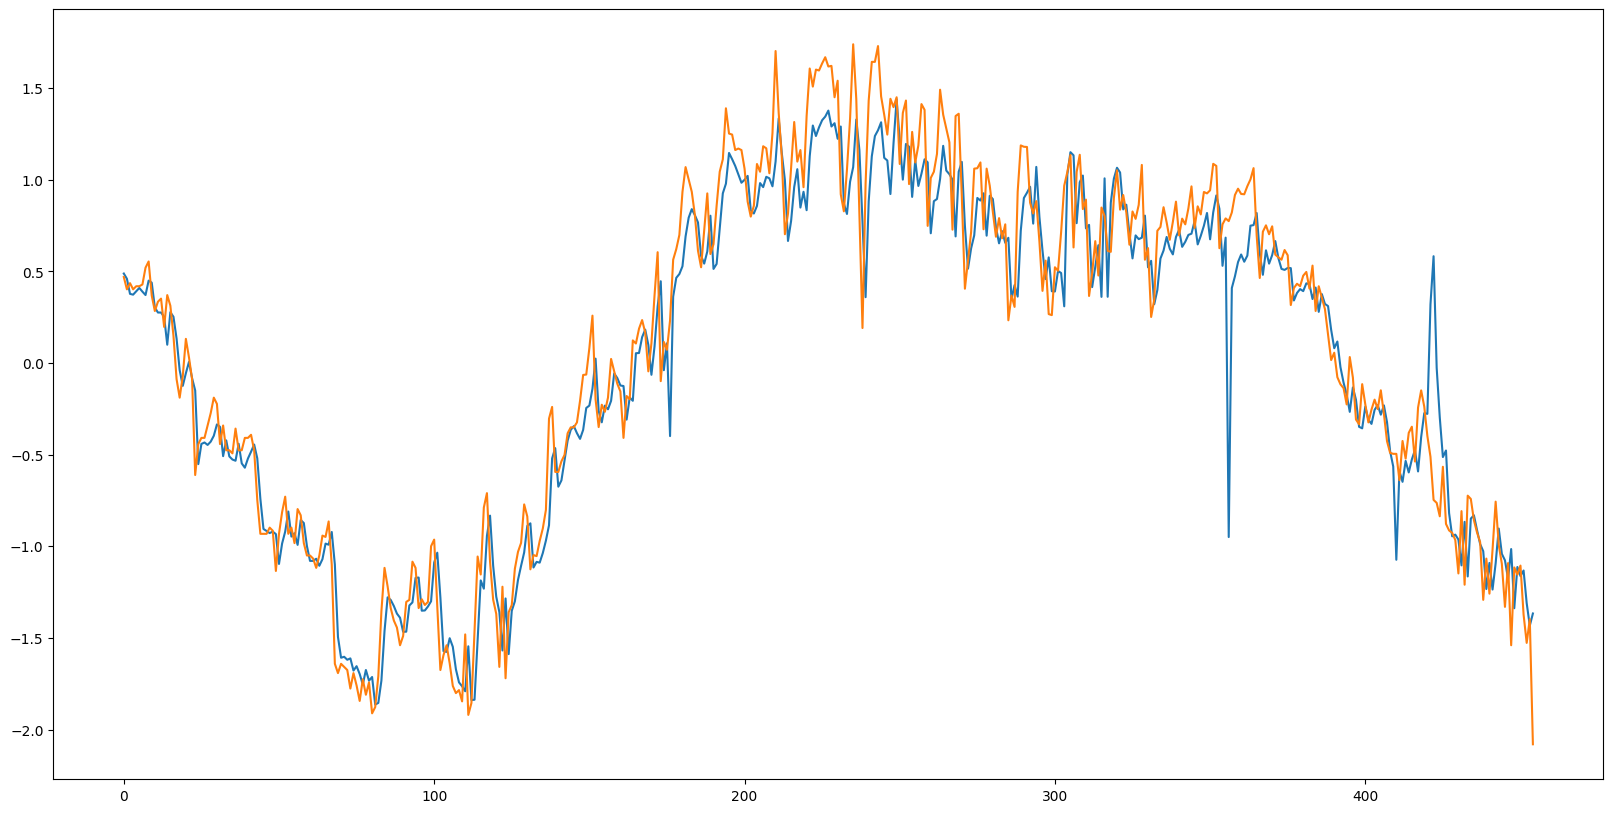

In [125]:
plot_predictions(model5, x3_test, y3_test)